In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight
from operator import itemgetter 
from itertools import groupby 

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'control' in filename:
            
            im=cv2.imread(pa_control + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [7]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [8]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
            
        if y[ix][0] == 'control':
            labels.append([[y[ix][0],1]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [9]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [10]:
def time_step_acc(tes_data,x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test, verbose = 0)
    results.append(scores[1]*100)

    return results

# TEST SET

In [11]:
mid = ['C6', 'F11']
leb = ['D11', 'G4']
mep = ['F2', 'G10']
met = ['G5', 'B10']
oxy = ['G3', 'B8']

cyc = ['E4', 'G6']
dox = ['G8', 'D10']
olo = ['E7', 'B7']
ket = ['E10', 'B11']
orp = ['D8', 'B2']

In [12]:
#tot_well = [mid, leb, mep, met, oxy]
tot_well = [cyc, dox, olo, ket, orp]

In [13]:
#string_well = ['mid', 'leb', 'mep', 'met', 'oxy']
string_well = ['cyc', 'dox', 'olo', 'ket', 'orp']

In [14]:
tot_results_accuracy = []

In [15]:
rand = list(np.random.randint(1,1000,3))

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:11<00:00,  5.75s/it]

0it [00:00, ?it/s]
9it [00:00, 72.21it/s]
12it [00:00, 44.76it/s]
18it [00:00, 47.27it/s]
22it [00:00, 42.61it/s]
27it [00:00, 44.21it/s]
31it [00:00, 40.26it/s]
35it [00:00, 38.29it/s]
40it [00:00, 40.96it/s]
46it [00:01, 42.74it/s]
51it [00:01, 44.62it/s]
56it [00:01, 40.96it/s]
61it [00:01, 42.27it/s]
66it [00:01, 41.25it/s]
72it [00:01, 43.66it/s]

100%|██████████| 72/72 [00:00<00:00, 2230.73it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00057: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00010: early stopping


1it [21:45, 1305.57s/it]
100%|██████████| 2/2 [00:11<00:00,  5.61s/it]

0it [00:00, ?it/s]
8it [00:00, 79.99it/s]
11it [00:00, 53.22it/s]
17it [00:00, 54.73it/s]
21it [00:00, 45.59it/s]
26it [00:00, 45.10it/s]
31it [00:00, 42.65it/s]
35it [00:00, 40.47it/s]
40it [00:00, 42.71it/s]
46it [00:01, 43.70it/s]
51it [00:01, 44.56it/s]
56it [00:01, 43.21it/s]
61it [00:01, 43.67it/s]
66it [00:01, 38.00it/s]
72it [00:01, 43.13it/s]

100%|██████████| 72/72 [00:00<00:00, 2219.24it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00058: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00010: early stopping


2it [43:29, 1305.16s/it]
100%|██████████| 2/2 [00:10<00:00,  5.48s/it]

0it [00:00, ?it/s]
6it [00:00, 57.00it/s]
10it [00:00, 48.02it/s]
16it [00:00, 49.51it/s]
20it [00:00, 37.94it/s]
25it [00:00, 39.62it/s]
29it [00:00, 39.47it/s]
33it [00:00, 36.29it/s]
38it [00:00, 37.32it/s]
44it [00:01, 41.35it/s]
49it [00:01, 40.48it/s]
54it [00:01, 40.12it/s]
59it [00:01, 40.11it/s]
64it [00:01, 38.93it/s]
72it [00:01, 40.98it/s]

100%|██████████| 72/72 [00:00<00:00, 2163.22it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00105: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00004: early stopping


3it [1:12:36, 1437.66s/it]
100%|██████████| 2/2 [00:11<00:00,  5.65s/it]

0it [00:00, ?it/s]
8it [00:00, 72.99it/s]
11it [00:00, 43.91it/s]
17it [00:00, 47.46it/s]
21it [00:00, 42.02it/s]
26it [00:00, 41.62it/s]
31it [00:00, 40.26it/s]
35it [00:00, 30.87it/s]
39it [00:01, 31.16it/s]
43it [00:01, 30.99it/s]
48it [00:01, 33.83it/s]
52it [00:01, 33.59it/s]
57it [00:01, 35.92it/s]
61it [00:01, 32.81it/s]
66it [00:01, 34.93it/s]
72it [00:01, 37.61it/s]

100%|██████████| 72/72 [00:00<00:00, 2351.56it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00075: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00011: early stopping


4it [1:38:54, 1479.80s/it]
100%|██████████| 2/2 [00:11<00:00,  5.55s/it]

0it [00:00, ?it/s]
8it [00:00, 77.08it/s]
11it [00:00, 52.01it/s]
17it [00:00, 53.30it/s]
21it [00:00, 44.49it/s]
26it [00:00, 44.78it/s]
31it [00:00, 42.47it/s]
35it [00:00, 40.23it/s]
40it [00:00, 42.45it/s]
45it [00:01, 38.24it/s]
49it [00:01, 38.21it/s]
53it [00:01, 38.36it/s]
58it [00:01, 39.14it/s]
62it [00:01, 32.75it/s]
66it [00:01, 34.33it/s]
72it [00:01, 40.66it/s]

100%|██████████| 72/72 [00:00<00:00, 2323.73it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00084: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00008: early stopping


5it [2:05:47, 1509.40s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:10<00:00,  5.38s/it]

0it [00:00, ?it/s]
9it [00:00, 78.54it/s]
14it [00:00, 62.15it/s]
19it [00:00, 54.56it/s]
23it [00:00, 46.80it/s]
29it [00:00, 47.51it/s]
33it [00:00, 42.28it/s]
38it [00:00, 42.40it/s]
44it [00:00, 45.83it/s]
49it [00:01, 43.64it/s]
54it [00:01, 42.06it/s]
59it [00:01, 40.72it/s]
64it [00:01, 42.02it/s]
72it [00:01, 43.22it/s]

100%|██████████| 72/72 [00:00<00:00, 2173.59it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00054: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00009: early stopping


1it [19:49, 1189.52s/it]
100%|██████████| 2/2 [00:11<00:00,  5.61s/it]

0it [00:00, ?it/s]
6it [00:00, 58.31it/s]
10it [00:00, 48.39it/s]
16it [00:00, 50.01it/s]
20it [00:00, 43.69it/s]
25it [00:00, 44.98it/s]
30it [00:00, 45.12it/s]
34it [00:00, 34.17it/s]
40it [00:00, 37.69it/s]
46it [00:01, 39.78it/s]
51it [00:01, 42.02it/s]
56it [00:01, 42.09it/s]
61it [00:01, 43.71it/s]
66it [00:01, 38.55it/s]
72it [00:01, 41.30it/s]

100%|██████████| 72/72 [00:00<00:00, 2211.04it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00043: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00005: early stopping


2it [35:07, 1108.16s/it]
100%|██████████| 2/2 [00:11<00:00,  5.66s/it]

0it [00:00, ?it/s]
7it [00:00, 61.80it/s]
10it [00:00, 44.95it/s]
14it [00:00, 42.46it/s]
19it [00:00, 42.75it/s]
23it [00:00, 40.38it/s]
28it [00:00, 42.52it/s]
32it [00:00, 37.63it/s]
37it [00:00, 39.38it/s]
41it [00:01, 35.92it/s]
46it [00:01, 38.50it/s]
51it [00:01, 41.17it/s]
56it [00:01, 40.21it/s]
61it [00:01, 41.80it/s]
66it [00:01, 39.38it/s]
72it [00:01, 41.16it/s]

100%|██████████| 72/72 [00:00<00:00, 2234.41it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00063: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00012: early stopping


3it [58:25, 1195.07s/it]
100%|██████████| 2/2 [00:11<00:00,  5.56s/it]

0it [00:00, ?it/s]
9it [00:00, 71.21it/s]
12it [00:00, 50.21it/s]
18it [00:00, 51.27it/s]
22it [00:00, 35.49it/s]
26it [00:00, 35.70it/s]
31it [00:00, 36.13it/s]
35it [00:00, 31.51it/s]
40it [00:01, 34.88it/s]
45it [00:01, 36.77it/s]
49it [00:01, 36.83it/s]
54it [00:01, 36.96it/s]
58it [00:01, 35.86it/s]
62it [00:01, 33.76it/s]
66it [00:01, 35.02it/s]
72it [00:01, 38.14it/s]

100%|██████████| 72/72 [00:00<00:00, 2173.01it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00045: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00009: early stopping


4it [1:16:16, 1157.90s/it]
100%|██████████| 2/2 [00:11<00:00,  5.54s/it]

0it [00:00, ?it/s]
9it [00:00, 74.00it/s]
14it [00:00, 59.90it/s]
19it [00:00, 53.71it/s]
23it [00:00, 45.47it/s]
28it [00:00, 45.33it/s]
32it [00:00, 38.63it/s]
36it [00:00, 38.98it/s]
41it [00:00, 41.14it/s]
46it [00:01, 42.18it/s]
51it [00:01, 40.90it/s]
56it [00:01, 40.69it/s]
61it [00:01, 36.62it/s]
66it [00:01, 37.52it/s]
72it [00:01, 41.98it/s]

100%|██████████| 72/72 [00:00<00:00, 2137.09it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00064: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00009: early stopping


5it [1:38:44, 1184.92s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:11<00:00,  5.75s/it]

0it [00:00, ?it/s]
7it [00:00, 64.38it/s]
10it [00:00, 45.52it/s]
15it [00:00, 46.64it/s]
20it [00:00, 43.26it/s]
25it [00:00, 43.79it/s]
30it [00:00, 44.13it/s]
34it [00:00, 37.41it/s]
40it [00:00, 39.54it/s]
46it [00:01, 41.35it/s]
51it [00:01, 43.54it/s]
56it [00:01, 40.09it/s]
61it [00:01, 40.18it/s]
66it [00:01, 39.26it/s]
72it [00:01, 42.03it/s]

100%|██████████| 72/72 [00:00<00:00, 1846.13it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00075: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00007: early stopping


1it [23:28, 1408.37s/it]
100%|██████████| 2/2 [00:10<00:00,  5.47s/it]

0it [00:00, ?it/s]
9it [00:00, 74.94it/s]
12it [00:00, 42.60it/s]
18it [00:00, 45.14it/s]
22it [00:00, 41.54it/s]
27it [00:00, 42.26it/s]
31it [00:00, 34.29it/s]
35it [00:00, 34.51it/s]
40it [00:00, 38.03it/s]
46it [00:01, 40.26it/s]
51it [00:01, 42.68it/s]
56it [00:01, 42.29it/s]
61it [00:01, 43.29it/s]
66it [00:01, 33.60it/s]
72it [00:01, 39.69it/s]

100%|██████████| 72/72 [00:00<00:00, 1512.95it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00083: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00007: early stopping


2it [49:21, 1451.87s/it]
100%|██████████| 2/2 [00:11<00:00,  5.57s/it]

0it [00:00, ?it/s]
9it [00:00, 72.12it/s]
12it [00:00, 50.61it/s]
17it [00:00, 47.37it/s]
20it [00:00, 39.63it/s]
25it [00:00, 40.72it/s]
29it [00:00, 38.98it/s]
33it [00:00, 35.72it/s]
38it [00:00, 37.04it/s]
43it [00:01, 40.10it/s]
49it [00:01, 42.64it/s]
54it [00:01, 40.94it/s]
59it [00:01, 40.47it/s]
64it [00:01, 38.94it/s]
72it [00:01, 41.87it/s]

100%|██████████| 72/72 [00:00<00:00, 1613.22it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00115: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00009: early stopping


3it [1:23:14, 1626.04s/it]
100%|██████████| 2/2 [00:10<00:00,  5.48s/it]

0it [00:00, ?it/s]
7it [00:00, 64.42it/s]
11it [00:00, 50.19it/s]
17it [00:00, 51.70it/s]
21it [00:00, 41.97it/s]
26it [00:00, 41.92it/s]
31it [00:00, 39.48it/s]
35it [00:00, 37.88it/s]
40it [00:00, 39.30it/s]
45it [00:01, 39.66it/s]
49it [00:01, 38.06it/s]
54it [00:01, 38.10it/s]
58it [00:01, 37.64it/s]
62it [00:01, 34.49it/s]
66it [00:01, 35.63it/s]
72it [00:01, 39.80it/s]

100%|██████████| 72/72 [00:00<00:00, 2123.97it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00062: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00012: early stopping


4it [1:46:49, 1562.95s/it]
100%|██████████| 2/2 [00:11<00:00,  5.60s/it]

0it [00:00, ?it/s]
6it [00:00, 56.87it/s]
9it [00:00, 44.65it/s]
12it [00:00, 37.59it/s]
18it [00:00, 41.26it/s]
22it [00:00, 39.23it/s]
27it [00:00, 41.93it/s]
31it [00:00, 39.29it/s]
35it [00:00, 38.22it/s]
39it [00:00, 36.94it/s]
44it [00:01, 39.51it/s]
48it [00:01, 38.18it/s]
52it [00:01, 35.78it/s]
57it [00:01, 38.41it/s]
61it [00:01, 33.24it/s]
66it [00:01, 34.62it/s]
72it [00:01, 38.93it/s]

100%|██████████| 72/72 [00:00<00:00, 2211.20it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00090: early stopping
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Epoch 00005: early stopping


5it [2:13:30, 1602.20s/it]


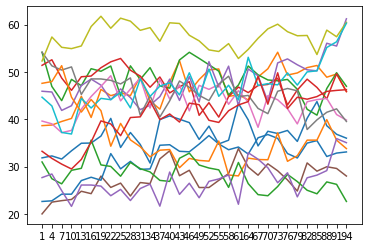

In [16]:
for num_ix, rand_num in enumerate(rand):

    for index_t_well, _ in tqdm.tqdm(enumerate(tot_well)):

        time_points = list(map(str, range(1,97,3)))

        new_time = []
        for i in time_points:
            r = '_' + i + '.'
            new_time.append(r)



        path_test = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/HRH_cropped/'

        # NAME OF THE WELLS CORRESPONDING TO THE FRUG THAT YOU WANT IN THE TEST SET 

        wells_drug = [tot_well[index_t_well][0], tot_well[index_t_well][1]] 

        test = []

        for _,_, filenames in os.walk(path_test):

            for filename in sorted(filenames, key = natural_keys):

                for w in wells_drug:
                    for t in new_time:
                        if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                            test.append(filename)


        groups_list = ['HRH', 'ADR']#, 'CONTROL']



        train = []

        validation = []

        group_compounds = []

        for group in tqdm.tqdm(groups_list):

            pa = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(group)

            for _,_, filenames in os.walk(pa):

                for filename in sorted(filenames, key = natural_keys):

                    for t in new_time:

                        if '_{}-'.format(wells_drug[0]) not in filename and '_{}-'.format(wells_drug[1]) not in filename and '{}tiff'.format(t) in filename:

                            group_compounds.append(filename)






        name =sorted(group_compounds)


        well = []
        for i in name:
            well.append(i.split('_id')[0])

        well_name = list(set(well))

        well_name = sorted(well_name)

        l = []
        for ix, _ in enumerate(well_name):
            n = []
            for i in name:
                if well_name[ix] in i:
                    n.append(i)
            l.append(n)


        tot_list = []

        for ix, i in tqdm.tqdm(enumerate(l)):


            id_n = []
            for j in l[ix]:
                id_n.append(j.split('_time')[0].split('_id_')[1])

            id_name = list(set(id_n))

            l1 = []
            for ixd, _ in enumerate(id_name):
                n1 = []
                for na in l[ix]:
                    if 'id_{}_time'.format(id_name[ixd]) in na:
                        n1.append(na)
                l1.append(n1)

            tot_list.append(l1)




        tra = []

        val = []

        for ie in tqdm.tqdm((range(len(tot_list)))):

            f_list = tot_list[ie]

            li = list(range((len(f_list))))

            f, s = train_test_split(li, test_size=0.2, random_state=rand_num)


            for i in f:

                tra.append(f_list[i])

            for v1 in s:
                val.append(f_list[v1])




        train = [i for sub in tra for i in sub]

        validation = [i for sub in val for i in sub]

        x_train = loadImages(train)
        y_train = make_labels(train)



        x_val = loadImages(validation)
        y_val = make_labels(validation)



        x_train = resize(x_train)


        x_val = resize(x_val)


        weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


        x_train = preprocess_input(x_train)

        x_val = preprocess_input(x_val)




        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

        pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

        base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

        batch_size = 128

        datagen = ImageDataGenerator()

        datagen.fit(x_train)

        train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

        dat_val = ImageDataGenerator()

        dat_val.fit(x_val)

        val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

        m4 = Sequential()
        m4.add(base_model)


        m4.add(BatchNormalization())
        m4.add(GlobalAveragePooling2D())
        m4.add(BatchNormalization())
        m4.add(Activation('relu'))
        m4.add(Dense(64, activation='relu'))
        m4.add(Dense(1,activation='sigmoid'))


        base_model.trainable = False

        opt = keras.optimizers.Adam(lr=1e-5)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = (val_gen), 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                         verbose = 0)

        base_model.trainable = True

        opt = keras.optimizers.Adam(lr=1e-5)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = val_gen, 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                        verbose = 0)


        l = []
        for t in new_time:
            for i in test:
                if t in i:
                    l.append((i))


        grouped = {}
        for elem in l:
            key = elem.split('.tiff')[0].split('_')[5]
            grouped.setdefault(key, []).append(elem)
        grouped = grouped.values()

        test_data = list(grouped)

        r = []

        for ix ,_ in enumerate(test_data):
            r.append(time_step_acc(test_data[ix],m4))

        plt.plot(time_points,r)
        plt.savefig('/home/jovyan/{}_accuracy{}.png'.format(string_well[index_t_well], num_ix))

        tot_results_accuracy.append(r)

    #p = '/home/jovyan/save_model_final/'
    #m4.save(p + "{}.h5".format(string_well[index_t_well]))

In [17]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, 5))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))
    


In [18]:
cv_s = cv_mean_acc(tot_results_accuracy, string_well)
cv_s

[(31.90669151954353, 'cyc'),
 (42.03670881688595, 'dox'),
 (48.54279728606343, 'olo'),
 (40.74064499388138, 'ket'),
 (40.63646229915321, 'orp')]

In [19]:
l_drug = string_well*3

acc_plot = []

for i in tot_results_accuracy:
    acc_plot.append(i)

cv_plot = list(zip(acc_plot, l_drug))

res_plot = sorted(cv_plot, key = lambda x: x[1])

a , b = zip(*res_plot)
    
a = list(a)

s = list(np.array_split(a, 5))

cv_plot = []

for ix, i in enumerate(s):
    s1 = list(s[ix])
    
    cv_plot.append(np.average(s1, axis=0))

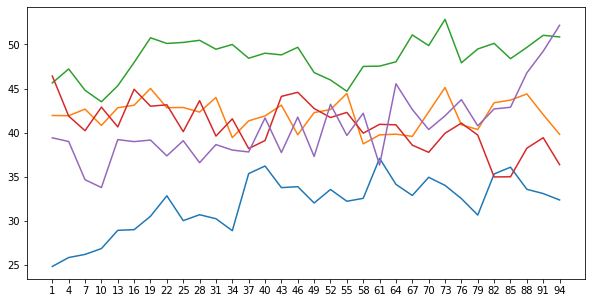

In [20]:
fig = plt.figure(figsize=(10, 5))
for i in cv_plot:
    
    plt.plot(time_points, i)
    plt.show
    plt.savefig('/home/jovyan/cv_score.png')